In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.path import Path

from collections import deque
from itertools import izip, chain

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes

from shapely.geometry import Polygon

from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'
    
from skimage.morphology import binary_closing, disk, binary_dilation, binary_erosion, remove_small_holes
from skimage.measure import find_contours, grid_points_in_poly, subdivide_polygon, approximate_polygon

import time
from collections import defaultdict

In [28]:
from registration_utilities import *

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
scoremaps_rootdir = '/home/yuncong/csd395/CSHL_scoremaps_lossless_svm_Sat16ClassFinetuned_v3//'
# autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotations_snake'
autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_labelings_losslessAlignCropped/'
autoAnnotationViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotationsViz_snake'

In [4]:
stack = 'MD603'

autoAnnotationViz_dir = create_if_not_exists(autoAnnotationViz_rootdir + '/' + stack)

first_bs_sec, last_bs_sec = section_range_lookup[stack]
first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

localAdjusted_volume = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_localAdjustedVolume.bp'%{'stack':stack})
print localAdjusted_volume.shape

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
    np.loadtxt(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_limits.txt' % {'stack': stack}), dtype=np.int)


volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

(472, 1056, 437)


In [5]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, 
                   int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

60 347


In [6]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(localAdjusted_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [7]:
dm = DataManager(stack=stack)

In [29]:
init_cnts_allSecs = load_initial_contours(initCnts_dir=volume_dir,
                                          stack=stack,
                                          test_volume_atlas_projected=localAdjusted_volume,
                                          z_xy_ratio_downsampled=z_xy_ratio_downsampled,
                                          volume_limits=(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax),
                                          labels=['BackG'] + labels_sided,
                                         force=False)

In [10]:
alpha_stats = defaultdict(list)

load image 4.773392 s
load scoremap 1.215863 s




272
set(['LRt_R', 'Amb_R', '7N_R', '7n_R', 'VLL_R', '5N_R'])
5N_R


initial shift 0.027153 s


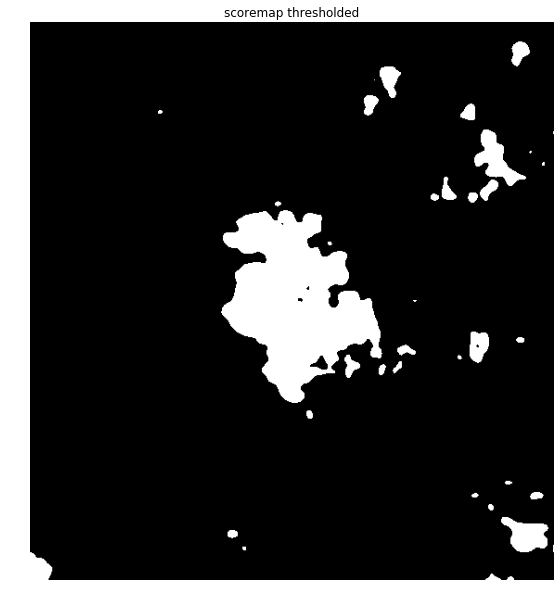

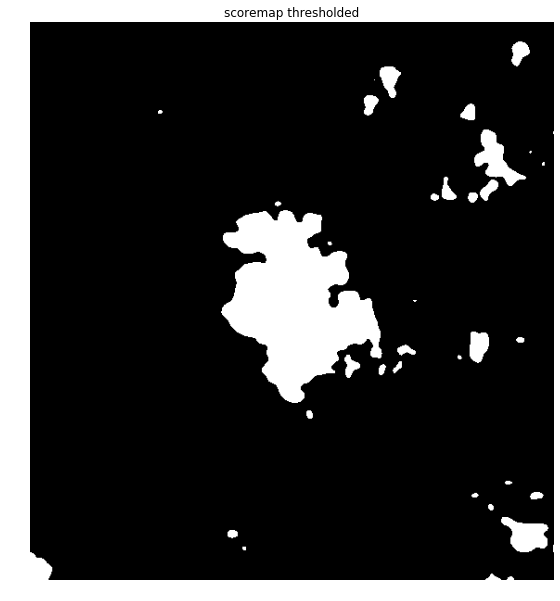

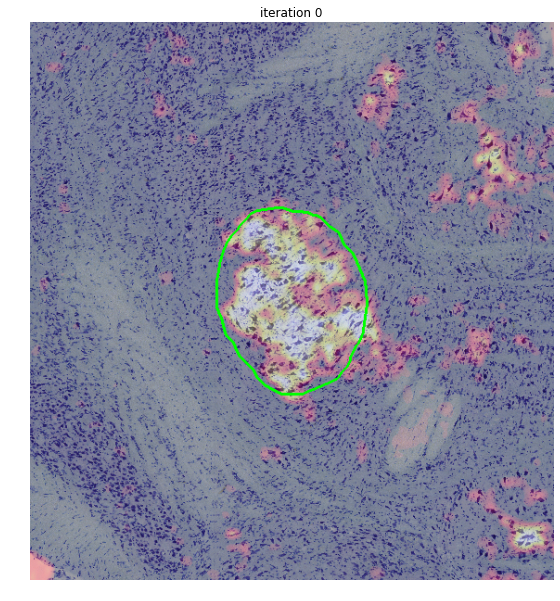

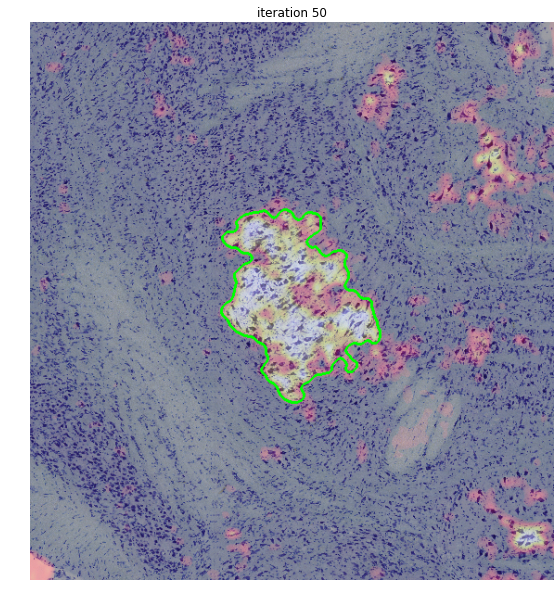

mean inside score: 0.69452
area: 20831
snake iteration: 50


snake completes 9.435899 s


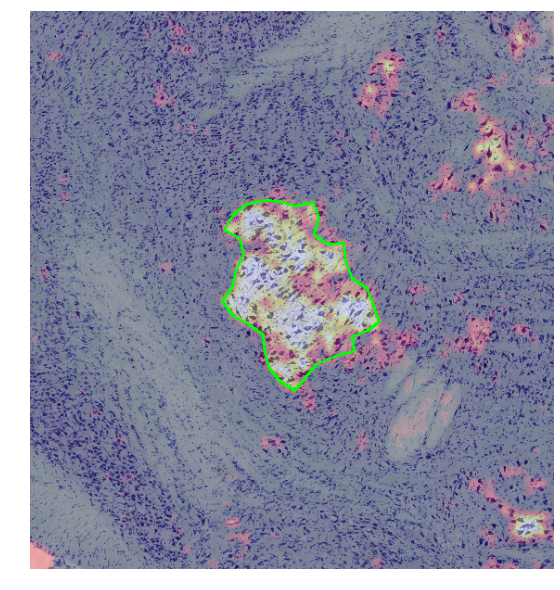

concave hull finishes 34.277230 s


In [31]:
# for sec in range(first_detect_sec, last_detect_sec+1):
# for sec in range(first_detect_sec, first_detect_sec+10):
for sec in SECTIONS if SECTIONS is not None else range(first_detect_sec, last_detect_sec+1):
# for sec in [157]:
    
    t = time.time()
    
    autoAnnotations_dir = create_if_not_exists(autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec)
        
    dm.set_slice(sec)
    dm._load_image(versions=['rgb-jpg'], force_reload=True)
    cropped_img = dm.image_rgb_jpg[::8, ::8]
        
    sys.stderr.write('load image %f s\n' % (time.time() - t))
    
    print '\n'
    print sec
    
    #########################
        
    init_cnts = init_cnts_allSecs[sec]

    labels_exist = set(init_cnts.keys())
    
    valid_labels = set(available_labels_sided) & labels_exist
    print valid_labels
    
    if len(valid_labels) == 0:
        sys.stderr.write('No valid labels exist.\n')
        continue

    new_res = []
    
    for l in valid_labels if SEE is None else SEE:
#     for l in ['7N']:
        
        print l
        
        t = time.time()
        
        dense_scoremap_lossless = pad_scoremap(stack, sec, labelMap_sidedToUnsided[l], scoremaps_rootdir=scoremaps_rootdir, 
                                               bg_size=(dm.image_height, dm.image_width))
        
        if dense_scoremap_lossless is None:
            dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
        
        scoremap0 = dense_scoremap_lossless[::8, ::8]
        scoremap = scoremap0.copy()
                
        # augment scoremaps, to make up for scoremap deficiencies
    
#         complement = {'LRt': ['7N'],
#                      '5N': ['7N'],
#                      'Pn': ['Amb', 'LC', 'SuVe'],
#                      'Tz': ['VLL'],
#                      '12N': ['7N'],
#                      'R': ['7N'],
#                       'LC': ['LRt'],
#                      'VLL': ['Pn', 'Tz', 'LC', 'LRt'],
#                      '7N': ['6N', 'LRt', 'LC'],
#                      'Sol': ['Pn']}
        
#         def augment_scoremap(ll):
#             global scoremap
#             m = pad_scoremap(stack, sec, ll, scoremaps_rootdir=scoremaps_rootdir,
#                              bg_size=(dm.image_height, dm.image_width))
            
#             if m is not None:
#                 scoremap = np.maximum(scoremap, m[::8, ::8])
        
#         if l in complement:
#             for ll in complement[l]:
#                 augment_scoremap(ll)
#             if l == 'Pn' and 'VLL' not in valid_labels:
#                 augment_scoremap('VLL')
#             if l == 'VLL' and 'Pn' not in valid_labels:
#                 augment_scoremap('Pn')
                    
        sys.stderr.write('load scoremap %f s\n' % (time.time() - t))
                    
        t = time.time()
        
        scoremap_height, scoremap_width = scoremap.shape[:2]

        init_cnt = init_cnts[l]

        if len(init_cnt) < 3:
            sys.stderr.write('initial contour has less than 3 vertices. \n')
            continue
            
#         init_cnt = contour_to_concave_hull(init_cnt, levelset=None, alpha=.01)
        
#         init_cnt = approximate_polygon(init_cnt, 5).astype(np.int)
#         init_cnt = subdivide_polygon(init_cnt, 5).astype(np.int)
        
        init_cnt_xmin, init_cnt_ymin = init_cnt.min(axis=0)
        init_cnt_xmax, init_cnt_ymax = init_cnt.max(axis=0)
        init_cnt_height, init_cnt_width = (init_cnt_ymax - init_cnt_ymin + 1, init_cnt_xmax - init_cnt_xmin + 1)
        init_cnt_cx, init_cnt_cy = np.mean(init_cnt, axis=0)
        
#         in_grid = grid_points_in_poly((init_cnt_height, init_cnt_width), init_cnt - (init_cnt_xmin, init_cnt_ymin))
        
        init_cnt_poly = Path(init_cnt)
        init_cnt_bbox_xs, init_cnt_bbox_ys = np.meshgrid(range(init_cnt_xmin, init_cnt_xmax+1), 
                                                         range(init_cnt_ymin, init_cnt_ymax+1))
        grid_points = np.c_[init_cnt_bbox_xs.flat, init_cnt_bbox_ys.flat]
        is_inside = init_cnt_poly.contains_points(grid_points)
        inside_points = grid_points[is_inside]
        
#         shift_best = np.array((0,0))
#         score_max = 0
#         for xshift in range(-200, 200, 10):
#             for yshift in range(-200, 200, 10):
#                 shifted_ys = inside_points[:,1] + int(yshift)
#                 shifted_xs = inside_points[:,0] + int(xshift)
#                 valid = (shifted_ys >= 0) & (shifted_ys < scoremap_height-1) & (shifted_xs >= 0) & (shifted_xs < scoremap_width-1)
#                 shifted_ys = shifted_ys[valid]
#                 shifted_xs = shifted_xs[valid]
#                 score = scoremap0[shifted_ys, shifted_xs].mean()
#                 if score_max < score:
#                     score_max = score
#                     shift_best = np.array([int(xshift), int(yshift)])
        
#         print 'initial shift', shift_best, score_max
                
#         if l == 'RtTg':
#             shift_best = (0, 0)
        shift_best = (0, 0)
        
#         init_cnt = init_cnt + shift_best
        init_cnt_xmin = max(init_cnt_xmin + shift_best[0], 0)
        init_cnt_ymin = max(init_cnt_ymin + shift_best[1], 0)
        init_cnt_xmax = min(init_cnt_xmax + shift_best[0], scoremap_width-1)
        init_cnt_ymax = min(init_cnt_ymax + shift_best[1], scoremap_height-1)
        
#         init_cnt_cx += shift_best[0]
#         init_cnt_cy += shift_best[1]
        inside_points += shift_best
        inside_points = inside_points[(inside_points[:,0] > init_cnt_xmin) & \
                                      (inside_points[:,0] < init_cnt_xmax) & \
                                      (inside_points[:,1] > init_cnt_ymin) & \
                                      (inside_points[:,1] < init_cnt_ymax)]
        
        sys.stderr.write('initial shift %f s\n' % (time.time() - t))
        
        
        roi_margin = max(200, (400-min(init_cnt_height, init_cnt_width))/2)
        # should be set to the largest landmark diameter (so that it is ok even if contour is placed at the end of it)
        
        roi_xmin, roi_ymin = (max(0, init_cnt_xmin - roi_margin), max(0, init_cnt_ymin - roi_margin))
        roi_xmax, roi_ymax = (min(scoremap_width-1, init_cnt_xmax + roi_margin), min(scoremap_height-1, init_cnt_ymax + roi_margin))
        roi_height, roi_width = (roi_ymax + 1 - roi_ymin, roi_xmax + 1 - roi_xmin)
                
        inside_points_inroi = inside_points - (roi_xmin, roi_ymin)
        
#         print 'init_cnt', init_cnt_xmin, init_cnt_ymin, init_cnt_xmax, init_cnt_ymax
#         print 'inside_points mins', inside_points.min(axis=0)
#         print 'inside_points maxs', inside_points.max(axis=0)
#         print 'inside_points_inroi mins', inside_points_inroi.min(axis=0)
#         print 'inside_points_inroi maxs', inside_points_inroi.max(axis=0)
#         print roi_xmin, roi_ymin, roi_xmax, roi_ymax, roi_width, roi_height
        
        scoremap_roi = scoremap[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1] 
                
        ######## landmark specific settings ########
        
        score_thresh = 0.3
        
#         if l == '12N':
#             score_thresh = 0.8
#         elif l == 'sp5':
#             score_thresh = 0.3
#         elif l == 'LRt':
#             score_thresh = 0.8
#         elif l == '7N':
#             score_thresh = 0.95
#         elif l == 'Pn':
#             score_thresh = 0.3
#         elif l == 'Tz':
#             score_thresh = 0.3
#         elif l == 'R':
#             score_thresh = 0.3
#         elif l == 'LC':
#             score_thresh = 0.3
#         elif l == '5N':
#             score_thresh = 0.3
#         elif l == 'VLL':
#             score_thresh = 0.3
#         elif l == 'Sol':
#             score_thresh = 0.3
#         else:
#             score_thresh = 0.8
            
        if l == 'sp5':
            smoothing = 1
        else:
            smoothing = 3
        
#         if l == 'Tz':
#             alphas = np.arange(.04, .16, .01)
#         elif l == 'LC':
#             alphas = np.arange(.08, .18, .01)
#         elif l == 'Pn':
#             alphas = np.arange(.03, .11, .01)
        # elif l == '7N':
        #     alphas = np.arange(.07, .12, .01)
#         if l == 'sp5':
#             alphas = np.arange(.20, 0.009, -.01) # using np.arange(.14, 0, -.01) results in weirdness
#         elif l == 'LRt':
#             alphas = np.arange(.20, 0.009, -.01)
# #             alphas = [.01]
#         else:
        alphas = np.arange(.20, 0.009, -.01)
            
        #############################################
    
        scoremap_thresholded = scoremap_roi > score_thresh
        
        if SHOW:
            plt.figure(figsize=(10, 10));
            plt.imshow(scoremap_thresholded, cmap=plt.cm.gray);
            plt.title('scoremap thresholded');
            plt.axis('off');
            plt.show();
        
        scoremap_thresholded_padded = np.zeros((roi_height + 100, roi_width + 100), np.bool)
        scoremap_thresholded_padded[50:-50, 50:-50] = scoremap_thresholded[:]
#         scoremap_thresholded_padded = binary_closing(scoremap_thresholded_padded, disk(10))

#         for _ in range(3):
#             scoremap_thresholded_padded = binary_dilation(scoremap_thresholded_padded, disk(3))
#         for _ in range(3):
#             scoremap_thresholded_padded = binary_erosion(scoremap_thresholded_padded, disk(3))

        scoremap_thresholded_padded = remove_small_holes(scoremap_thresholded_padded, 1000)
#         scoremap_thresholded_padded = remove_small_objects(scoremap_thresholded_padded, 100)
        scoremap_thresholded = scoremap_thresholded_padded[50:-50, 50:-50][:]

        if SHOW:        
            plt.figure(figsize=(10, 10));
            plt.imshow(scoremap_thresholded, cmap=plt.cm.gray);
            plt.axis('off');
            plt.title('scoremap thresholded');
            plt.show();
            
        init_levelset = np.zeros((roi_height, roi_width))
        init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.
        
        t = time.time()
        
        msnake = morphsnakes.MorphACWE(scoremap_thresholded.astype(np.float), smoothing=smoothing, lambda1=1., lambda2=1.)
        
        msnake.levelset = init_levelset.copy()
        # levelset values are either 1.0 or 0.0

#         scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_thresholded.astype(np.float))[..., :3])

        scoremap_roi2 = scoremap_roi.copy()
        scoremap_roi2[scoremap_roi > 1.] = 1.
        scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_roi2)[..., :3])
        scoremap_viz = img_as_ubyte(alpha_blending(scoremap_layer_viz,
                                                   cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1],
                                                   .3, 1))[..., :3]

#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_roi);
#         plt.title('scoremap');
#         plt.show();
        
#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_viz);
#         plt.title('scoremap thresholded');
#         plt.show();
        
        dq = deque([None, None])
        for i in range(1000): 
            
            # at stable stage, the levelset (thus contour) will oscilate, 
            # so instead of comparing to previous levelset, must compare to the one before the previous
            oneBefore_levelset = dq.popleft()
            
            if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
                if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
                    break

            dq.append(msnake.levelset)
        
            msnake.step()
            
            if SHOW:
                if i % 50 == 0:
                    show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        if SHOW:
            show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        # in the final levelset, inside could be 0. or 1., hard to say        
        edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
        pos_edge_num = np.count_nonzero(edge_arr)
        bool_arr = msnake.levelset.astype(np.bool)
        
        if pos_edge_num < len(edge_arr) - pos_edge_num:
            # inside is 1.
            mean_inside_score = scoremap_roi[bool_arr].mean()
        else:
            # inside is 0.
            mean_inside_score = scoremap_roi[~bool_arr].mean()
            msnake.levelset = 1. - msnake.levelset
        
        # after this, all inside pixels have value 1.
            
        print 'mean inside score:', mean_inside_score
        print 'area:', np.count_nonzero(bool_arr)
        print 'snake iteration:', i
        
        if mean_inside_score < .3:
            continue
        
        sys.stderr.write('snake completes %f s\n' % (time.time() - t))

#         m = binary_closing(msnake.levelset, disk(20))
#         plt.figure(figsize=(10,10));
#         plt.imshow(m);
#         plt.show();
        
        t = time.time()
    
        new_cnts = find_contours(msnake.levelset, 0.5)
        new_cnts = [c[:, ::-1] for c in new_cnts]
#         cnt_is_dense = True
        
#         if len(new_cnts) == 1:
#             new_cnt = new_cnts[0]
        if len(new_cnts) == 0:
            sys.stderr.write('No contour detected from snake levelset.\n')
            continue

        all_cnt_points = np.concatenate(new_cnts)
        
        new_cnt_subsampled, auto_alpha = contour_to_concave_hull(all_cnt_points.astype(np.int), 
                                                                 levelset=msnake.levelset, alphas=alphas)

        alpha_stats[l].append(auto_alpha)
        
        if new_cnt_subsampled is None:
            continue
    
        area_lowerlim = 1000
        area = Polygon(new_cnt_subsampled).area
        if area < area_lowerlim:
            sys.stderr.write('Concave hull area %d is too small.\n' % area)
            continue

        if SHOW:
            show_contours([new_cnt_subsampled], scoremap_viz, 'concave hull')
#             show_contours([new_cnt_subsampled, cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1], 'concave hull')

        new_cnt_subsampled = new_cnt_subsampled + (roi_xmin, roi_ymin)
        
        
        sys.stderr.write('concave hull finishes %f s\n' % (time.time() - t))

        
        new_lm = {}
        new_lm['label'] = l
        new_lm['vertices'] = new_cnt_subsampled.astype(np.int) * 8
        new_lm['labelPos'] = new_lm['vertices'].mean(axis=0)
        new_lm['refVertices'] = np.array(init_cnt).copy() * 8
        new_lm['subtype'] = PolygonType.CLOSED
            
        new_res.append(new_lm)
        
    ######################################
    
#     if not SHOW:
    
#         timestamp = datetime.datetime.now().strftime("%m%d%Y%H%M%S")

#         autoAnnotation_filepath = autoAnnotations_dir + '/%(stack)s_%(sec)04d_autoAnnotate_%(timestamp)s_consolidated.pkl' % \
#                             {'stack': stack, 'sec': sec, 'timestamp': timestamp}

#         pickle.dump(new_res, open(autoAnnotation_filepath, 'w'))   
        
    ######################################

In [24]:
SECTIONS = [272]
# SECTIONS = None
SHOW = True
# SHOW = False
SEE = ['5N_R']
# SEE = None

In [ ]:
viz = cropped_img.copy()

for l in valid_labels:
    ref_cnt = init_cnts[l].astype(np.int)
    for xy in ref_cnt:
        cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

for lm in new_res:

# for pt in init_cnt:
#     cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

#         ref_cnt = lm['refVertices'].astype(np.int)
#         for xy in ref_cnt:
#             cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

    new_cnt = np.array(lm['vertices'])/8

    for xy in new_cnt:
        cv2.circle(viz, tuple(xy), 5, (255,0,0), -1)
    cv2.polylines(viz, [new_cnt.astype(np.int)], True, (255,0,0), 2)

#     if sec in section_contains_label and lm['label'] in section_contains_label[sec]:
#         dm = DataManager(stack=stack, section=sec)
#         user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
#         manual_cnt = [x['vertices'] for x in res if x['label'] == lm['label']][0]
#         manual_cnt = np.array(manual_cnt)/8

#         for xy in manual_cnt.astype(np.int):
#             cv2.circle(viz, tuple(xy), 3, (0,0,255), -1)
#         cv2.polylines(viz, [manual_cnt.astype(np.int)], True, (0,0,255), 2)

    lx, ly = np.array(lm['labelPos'])
    cv2.putText(viz, lm['label'], (int(lx)-10, int(ly)+10), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

# if not SHOW:
#     cv2.imwrite(autoAnnotationViz_dir + '/%(stack)s_%(sec)04d_autoAnnotationViz.jpg' % \
#                 {'stack': stack, 'sec': sec}, viz[..., ::-1])

In [ ]:
display_image(viz)

In [ ]:
if l == 'Tz':
    alphas = np.arange(.04, .16, .01)
elif l == 'LC':
    alphas = np.arange(.08, .18, .01)
elif l == 'Pn':
    alphas = np.arange(.03, .11, .01)
# elif l == '7N':
#     alphas = np.arange(.07, .12, .01)

In [ ]:
# for l, q in alpha_stats.iteritems():
#     plt.figure(figsize=(10,5))
#     plt.title(l)
#     plt.hist(q, bins=20)
#     plt.xticks(alphas)
# #     plt.xticks(range(len(alphas)), alphas)
#     plt.show()

In [ ]:
# For MICCAI 
show_contours([new_cnt_subsampled - (roi_xmin, roi_ymin)], 
              cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1], 'concave hull')

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(20,20), sharex=True, sharey=True);
axes = axes.flatten()
for i, (l, sm) in enumerate(dense_scoremap_lossless_others.iteritems()):
    axes[i].imshow(sm[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1]);
    axes[i].set_title(l);
plt.show();

In [ ]:
# ISSUES:
# - if initial contour (shifted) does not cover some broken part of the hotness, 
# this part will never be considered no matter how hot it is

# - boundary inaccuracy should be improved by taking surrounding as negatives in a more pinpointy way.
# - the fact that one part is judged to be one class should  explain away its probability in other places: need a global model

In [ ]:
plt.figure(figsize=(15, 15));
plt.imshow(viz);

In [ ]:
cnt = all_cnt_points.astype(np.int)

xmin, ymin = cnt.min(axis=0)
xmax, ymax = cnt.max(axis=0)

xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
gridpoints = np.c_[xs.flat, ys.flat]
inside_indices = np.where(msnake.levelset[gridpoints[:,1], gridpoints[:,0]] > 0)[0]
n = inside_indices.size
random_indices = np.random.choice(range(n), min(5000, n), replace=False)
inside_points = gridpoints[inside_indices[random_indices]]
concave_hull = alpha_shape(inside_points, alphas=[.01])[0]
# print len(concave_hull)
print concave_hull.area
concave_hull

In [ ]:
cnt = all_cnt_points.astype(np.int)

xmin, ymin = cnt.min(axis=0)
xmax, ymax = cnt.max(axis=0)
h, w = (ymax-ymin+1, xmax-xmin+1)
inside_ys, inside_xs = np.where(grid_points_in_poly((h, w), cnt[:, ::-1]-(ymin,xmin))) 
n = inside_ys.size
random_indices = np.random.choice(range(n), min(1000, n), replace=False)
inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]]
concave_hull = alpha_shape(inside_points, alpha=.6)
concave_hull

In [ ]:
new_cnt_subsampled, auto_alpha = contour_to_concave_hull(all_cnt_points.astype(np.int), msnake.levelset, alphas=[.01])
plt.scatter(all_cnt_points[::5,0], all_cnt_points[::5,1], c='g');
plt.scatter(new_cnt_subsampled[:,0], new_cnt_subsampled[:,1]);
plt.axis('equal');

In [ ]:
# For MICCAI paper (image, scoremap, atlas projected contours)

sec = 143

autoAnnotations_dir = autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec
if not os.path.exists(autoAnnotations_dir):
    os.makedirs(autoAnnotations_dir)

dm = DataManager(stack=stack, section=sec)
dm._load_image(versions=['rgb-jpg'])
cropped_img = dm.image_rgb_jpg[::8, ::8]

print '\n'
print sec

#########################

z_lowerlim = int(z_xy_ratio_downsampled*sec) - volume_zmin
z_nextsec = int(z_xy_ratio_downsampled*(sec+1)) - volume_zmin
z_previous = int(z_xy_ratio_downsampled*(sec-1)) - volume_zmin

projected_annotation_labelmap = test_volume_atlas_projected[..., z_lowerlim]

init_cnts = find_contour_points(projected_annotation_labelmap) # downsampled 16
init_cnts = dict([(labels[label_ind], (cnts[0]+(volume_xmin, volume_ymin))*2) 
                  for label_ind, cnts in init_cnts.iteritems()])

# This has problems because some lms can not be detected even if there are some of their pixels on the map
#     label_indices_exist = set(np.unique(projected_annotation_labelmap))

#     label_indices_exist = set(np.r_[np.unique(test_volume_atlas_projected[..., z_nextsec]),
#                                 np.unique(test_volume_atlas_projected[..., z_previous]), 
#                                 np.unique(projected_annotation_labelmap)])

#     labels_exist = set([labels[i] for i in label_indices_exist])

labels_exist = set(init_cnts.keys())

valid_labels = labels_to_detect & labels_exist
print valid_labels

# if len(valid_labels) == 0:
#     sys.stderr.write('No valid labels exist.\n')
#     continue

# new_res = []

l = '7n'

print l

# try:
scoremap_whole = bp.unpack_ndarray_file(os.path.join(scoremaps_dir, 
                                           '%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s.bp' % \
                                           {'stack': stack, 'sec': sec, 'label': l}))
# except:
#     sys.stderr.write('No scoremap of %s exists\n' % (l))
#     continue


dataset = stack + '_' + '%04d'%sec + '_roi1'

interpolation_xmin, interpolation_xmax, \
interpolation_ymin, interpolation_ymax = np.loadtxt(os.path.join(scoremaps_dir, 
                                                                 '%(dataset)s_denseScoreMapLossless_%(label)s_interpBox.txt' % \
                                {'dataset': dataset, 'label': l})).astype(np.int)

dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
dense_scoremap_lossless[interpolation_ymin:interpolation_ymax+1,
                        interpolation_xmin:interpolation_xmax+1] = scoremap_whole

scoremap = dense_scoremap_lossless[::8, ::8]
scoremap_height, scoremap_width = scoremap.shape[:2]

scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap)[..., :3])
scoremap_viz = img_as_ubyte(alpha_blending(scoremap_layer_viz,
                                           cropped_img,
                                           .3, 1)[..., :3])

vertices = init_cnts[l]

#     for x,y in vertices:
#         cv2.circle(viz, (int(x), int(y)), 5, (0,0,255), -1)
cv2.polylines(scoremap_viz, [vertices.astype(np.int)], True, (255,0,0), 5)

#             lx, ly = np.array(ann['labelPos']) / downscale_factor
#             cv2.putText(viz, ann['label'], (int(lx)-10, int(ly)+10), 
#                         cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 2)

#                 label_texts.add(ann['label'])

display(scoremap_viz)